<a href="https://colab.research.google.com/github/sandowm/aml-motion-android/blob/master/model/HAR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
ongoogle = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    ongoogle=True
    datadir='/content/drive/My Drive/CAS AML HAR/motion-sense/data'
    os.chdir('/content/drive/My Drive/CAS AML HAR/motion-sense/data')
    sys.path.insert(0,'/content/drive/My Drive/CAS AML HAR/motion-sense/data')
except ModuleNotFoundError:
    os.chdir('d:/data/unibe/CAS-AML-Motion/motion-sense/data')
    
    #%tensorflow_version 1.x

from matplotlib import  pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
#from imageio import imread
import pickle
from PIL import Image
from time import time as timer
import requests
import zipfile
import time
import os
import csv
import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import IPython


#import umap
from scipy.stats import entropy
import re

Adatadir=os.path.join(datadir,'A_DeviceMotion_data')
squeeze = 50
subjectre=re.compile('sub_([0-9]+)\.csv')
labels= []
for i in range(squeeze):
    labels += ["attitude.roll","attitude.pitch","attitude.yaw","userAcceleration.x","userAcceleration.y","userAcceleration.z"] 

activity = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
data_array=[]

def get_csv_raw(csvfile):
    reader = csv.reader(csvfile)
    raw = []
    rawidx=-1
    for row in reader:
        # Skip Header
        if reader.line_num <=1: continue
        lineindex=int(row[0])
        if lineindex % squeeze == 0:
            rawidx += 1
            raw.append([])
        rawrow = []
        # Get Attitude (1-3) and userAcceleration (10-12) from each line
        for i in [1,2,3,10,11,12]: 
            try:
                rawrow += [ float(row[i]) ]
            except:
                # Replace invalid values by 0
                rawrow += [ 0.0 ]
        # Add label as last elements of each squeezed row, the three zeroes are for magnetometer values
        rawrow += [ 0, 0, 0, subjectNr, activity[act] ]
        rawrow2 = []
        for i in rawrow:
            rawrow2 += [ [ i ] ]
        raw[rawidx] += [ rawrow2 ]
    return raw[:rawidx-1]

exercise_raw=[]
for exercise in os.listdir(Adatadir):
    act = exercise.split('_')[0]
    print (act)
    for subjectFile in os.listdir(os.path.join(Adatadir,exercise)):
        m = subjectre.search(subjectFile)
        subjectNr = int(m.group(1))
        if subjectNr < 22:
            exercise_raw += get_csv_raw(open(os.path.join(Adatadir,exercise,subjectFile)))

            
vals = np.zeros((len(exercise_raw), len(exercise_raw[0]), len(exercise_raw[0][0]),1))
for i in range(len(exercise_raw)-1):
    for k in range(squeeze-1):
        vals[i,k] = exercise_raw[i][k]
vals.shape

Mounted at /content/drive
ups
wlk
std
wlk
sit
std
jog
ups
wlk
sit
ups
dws
dws
jog
dws


(24550, 50, 11, 1)

In [3]:
vals[9,2]

array([[ 0.33794 ],
       [-0.740321],
       [ 0.901958],
       [-0.048138],
       [ 0.268575],
       [ 0.367852],
       [ 0.      ],
       [ 0.      ],
       [ 0.      ],
       [ 1.      ],
       [ 4.      ]])

In [4]:
from sklearn.model_selection import train_test_split
X=vals[:,:,:9]
Y=vals[:,0,10,0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=777)


n_train=X_train.shape[0]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, n_train)
print(Y_train[419:450])


(19640, 50, 9, 1) (19640,) (4910, 50, 9, 1) (4910,) 19640
[2. 2. 1. 1. 1. 4. 0. 5. 3. 5. 4. 3. 4. 3. 5. 2. 5. 1. 2. 3. 1. 2. 1. 0.
 2. 2. 4. 5. 4. 5. 5.]


In [5]:
# https://github.com/mmalekzadeh/dana
%env PYTHONPATH="/env/python:/content/drive/My Drive/CAS AML HAR/motion-sense/data"
from dana import models as dana_models
from dana import trainers as dana_trainers



env: PYTHONPATH="/env/python:/content/drive/My Drive/CAS AML HAR/motion-sense/data"


In [6]:
## If you do not want your own data....
## Download and UnZip UTwente Dataset into the Path: dana/datasets/Utwente
## https://www.utwente.nl/en/eemcs/ps/dataset-folder/ut-data-complex.rar
def lulu():
  from dana.datasets import utwente
  (X_train, Y_train, X_test, Y_test, data_class_names, data_class_weights) = utwente.load_data(shuffle=False)

  rnd_seed = 0
  tf.random.set_seed(rnd_seed)
  np.random.RandomState(seed=rnd_seed).permutation(len(X_train))
  indices = np.random.permutation(len(X_train))
  X_train = X_train[indices]
  Y_train = Y_train[indices] 

  X_train = np.expand_dims(X_train,3)
  X_test = np.expand_dims(X_test,3)
  print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
  print("Activity Weights",dict(zip(data_class_names,data_class_weights.values())))
# lulu()

In [7]:
def test_model(model, X_val, Y_val, batch_size, W_comb=None, H_comb=None):
    if not W_comb:
        W_comb = X_val.shape[1]
    if not H_comb:
        H_comb = list(range(X_val.shape[2]))
    val_accuracy = tf.keras.metrics.Accuracy()
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
    val_dataset = val_dataset.batch(batch_size)        
    for (X, Y) in val_dataset:
        X = X.numpy()                                    
        X = X[:,:,H_comb,:]                     
        X = tf.image.resize(X, (W_comb, len(H_comb)))
        logits = model(X)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        val_accuracy(prediction, Y)        
    return val_accuracy.result()

In [8]:
W_combinations = list(np.arange(16,129,16))
H_combinations = [[0,1,2], [3,4,5], [6,7,8], 
                  [0,1,2,3,4,5], [0,1,2,6,7,8],
                  [3,4,5,0,1,2], [3,4,5,6,7,8],
                  [6,7,8,0,1,2], [6,7,8,3,4,5],
                  [0,1,2,3,4,5,6,7,8],[0,1,2,6,7,8,3,4,5],
                  [3,4,5,0,1,2,6,7,8],[3,4,5,6,7,8,0,1,2], 
                  [6,7,8,3,4,5,0,1,2],[6,7,8,0,1,2,3,4,5]] ## Acc & Gyr & Mgn

W_combinations_validation = W_combinations
H_combinations_validation = [[0,1,2], [3,4,5], [6,7,8], 
                  [0,1,2,3,4,5], [0,1,2,6,7,8],[3,4,5,6,7,8],
                  [0,1,2,3,4,5,6,7,8]]
n_batch_per_train_setp = 5

In [10]:
data_class_weights={0:1.0,1:1.0,2:1.0,3:1.0,4:1.0,5:1.0}
runs = np.arange(1,2)
for run in runs:
    ## ["standard", "reptile", "weight_avg", "dat"]
    for method in  ["dat"]:   
        history_accuracy = []
        history_time = []
        # len(np.unique(y_train))
        model = dana_models.Ordonez2016DeepWithDAP((None, None, 1),(128) , (8,9))
        print(model.summary())

        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
        optimizer = tf.keras.optimizers.Adam()
        # print("**__** Run {} -- Method {}".format(run, method))
        trainer = dana_trainers.ModelTrainer(model, loss_fn, optimizer, data_class_weights,
                                              num_epochs=1000, batch_size=128, patience=100,
                                              W_combinations=W_combinations,
                                              H_combinations=H_combinations,
                                              W_combinations_validation=W_combinations_validation,
                                              H_combinations_validation=H_combinations_validation,
                                              n_batch_per_train_setp=n_batch_per_train_setp)
        save_dir_model="saved_models/ms2_exp_ut_dana/Ordonez2016DeepWithDAP_2_"+method+"_"+\
              str((len(W_combinations),len(H_combinations),n_batch_per_train_setp))+"/best_"+str(run)
       
        ##### Uncomment this if you want to train the model
        train_it = False
        if train_it:
          _, best_accuracy_record, avg_training_time = trainer.train_model(X_train[len(X_train)//10:], Y_train[len(X_train)//10:],
                                                                          X_train[:len(X_train)//10], Y_train[:len(X_train)//10],
                                                                          method,
                                                                         save_dir=save_dir_model,
                                                                         verbose=10)

          history_accuracy.append(best_accuracy_record)
          history_time.append(avg_training_time)
          save_dir_results = "saved_models/exp_ut_dana/Ordonez2016DeepWithDAP_2_"+method+"_"+\
              str((len(W_combinations),len(H_combinations),n_batch_per_train_setp))
          if not os.path.exists(save_dir_results):
              os.makedirs(save_dir_results)
          np.save(save_dir_results+"/accuracy_results_"+str(run)+".npy", history_accuracy)
          np.save(save_dir_results+"/timing_results_"+str(run)+".npy", history_time)
        #####

        model.load_weights(save_dir_model)   
        best_accuracy_record = np.zeros((len(W_combinations_validation),len(H_combinations_validation)))
        for w in range(len(W_combinations_validation)):
            for h in range(len(H_combinations_validation)):
                best_accuracy_record[w,h] = test_model(model, X_test, Y_test, 128,
                                                    W_combinations_validation[w],
                                                    H_combinations_validation[h])
        
        print("\n Run {} *** Mean of Test Accuraccies: {:.3f}".format(run, np.mean(best_accuracy_record)))
        print("\n Run {} *** Test Accuraccies: {} ".format(run, (best_accuracy_record)))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    384       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    20544     
_________________________________________________________________
DAP (DimensionAdaptivePoolin (None, 8, 576)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 128)            3609

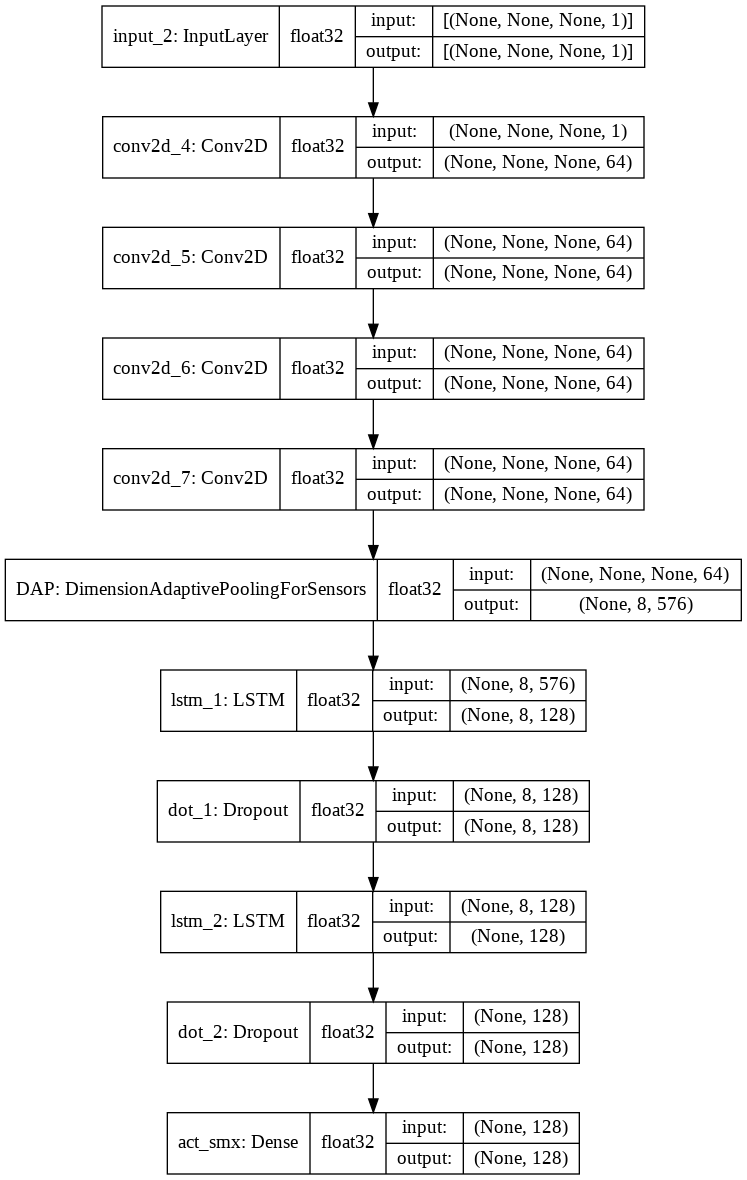

In [12]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)